<a href="https://colab.research.google.com/github/jinnyjinny/DogFaceClassification/blob/master/df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 실행 전에 주의할 점

- GPU 가속기에서 코드 실행 (CPU에서 실행 불가)

# Dependency

In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=c0bd3c9f01ca9f2657d7bcb83fdeb4d158fe2fb656842236d99d5f6c2297d7f6
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [4]:
import keras
import tensorflow as tf
import dlib, cv2, os 
from imutils import face_utils # imutils : 이미지  처리, dlib shape -> numpy ndarray로 자동변환
from sklearn.cluster import KMeans
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import os
import csv

# Visualized Sample Image


Detection 0: Left: 202 Top: 60 Right: 406 Bottom: 264 Confidence: 1.022109031677246


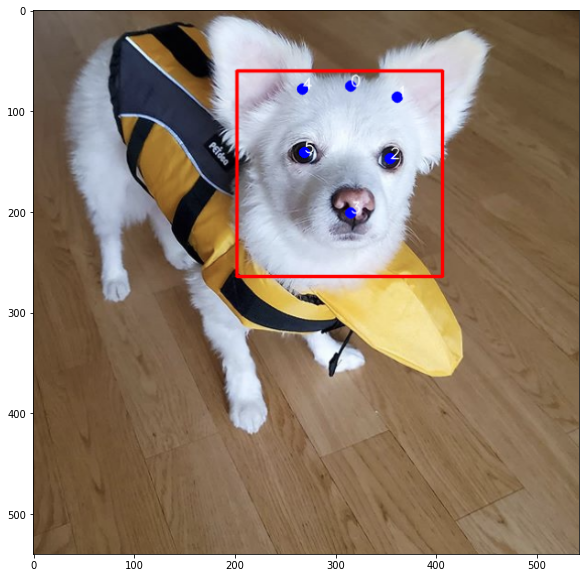

In [ ]:
##### Load Model #####
detector = dlib.cnn_face_detection_model_v1('/content/drive/My Drive/Cap/dogHeadDetector.dat')
predictor = dlib.shape_predictor('/content/drive/My Drive/Cap/landmarkDetector.dat')

img_path = '/content/drive/My Drive/Cap/data/real/train/zzo/zzo_5.png'
filename, ext = os.path.splitext(os.path.basename(img_path))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Detect Face
dets = detector(img, upsample_num_times=1)
img_result = img.copy()

for i, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

    x1, y1 = d.rect.left(), d.rect.top()
    x2, y2 = d.rect.right(), d.rect.bottom()

    cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)

# Detect Landmarks
shapes = []

for i, d in enumerate(dets):
    shape = predictor(img, d.rect)
    shape = face_utils.shape_to_np(shape)
    re = shape.reshape(-1) # x0 y0 x1 y1 x2 y2 x3 y3 x4 y4 x5 y5     
    for i, p in enumerate(shape):
        shapes.append(shape)
        cv2.circle(img_result, center=tuple(p), radius=5, color=(0,0,255), thickness=-5, lineType=cv2.LINE_AA)
        cv2.putText(img_result, str(i), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

img_out = cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10, 10))
plt.imshow(img_result)

# Ratio between two eyes and nose

In [5]:

#### 삼각존 df1 ####

def rgb_ratio(DOG_FOLDER_PATH):

    ##### Load Model #####
    detector = dlib.cnn_face_detection_model_v1('/content/drive/My Drive/Cap/dogHeadDetector.dat')
    predictor = dlib.shape_predictor('/content/drive/My Drive/Cap/landmarkDetector.dat')

    ##### Load Image #####
    dog_folder_path = DOG_FOLDER_PATH
    dog_folder_list = os.listdir(dog_folder_path)
    dog_folder_list.sort()
    print(dog_folder_list)
    
    df1 = pd.DataFrame(columns=['index' ,'ratio'])
    for f in dog_folder_list:
        img_path = dog_folder_path + '/' + f
        img = cv2.imread(img_path)
        index = str(f.split('.')[0]) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ##### Detect Face #####
        dets = detector(img, upsample_num_times=2)
        img_result = img.copy()
        
        
        for i, d in enumerate(dets):
            #print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))
            x1, y1 = d.rect.left(), d.rect.top()
            x2, y2 = d.rect.right(), d.rect.bottom()
         
            cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
        
        
        ##### Detect Landmarks #####
        for i, d in enumerate(dets):
            shape = predictor(img, d.rect) # detect in range of d.rect 
            shape = face_utils.shape_to_np(shape)
            shape = shape.reshape(-1) # x0 y0 x1 y1 x2 y2 x3 y3 x4 y4 x5 y5
            ##### Landmarks Ratio #####
            x3 = int(shape[6])
            y3 = int(shape[7])
            x5 = int(shape[10])
            y5 = int(shape[11])
            x2 = int(shape[4])
            y2 = int(shape[5])
            area = abs ( (x5 - x3) * (y2 - y3) - (y5 - y3) * (x2 - x3) )
            AB = ( (x5 - x2) ** 2 + (y5 - y2) ** 2 ) ** 0.5
            ratio =  (area / AB) * 0.01
            ratio = round(ratio, 4)
        

            df1 = df1.append(pd.DataFrame([[index, ratio]], columns=['index','ratio']), ignore_index=True)
    print(df1)
    ##### RGB Pixel #####
    r = []
    g = []
    b = []
    for f in dog_folder_list:
        img_path = dog_folder_path + '/' + f
        
        img = cv2.imread(img_path)
        index = str(f.split('.')[0]) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape((img.shape[0] * img.shape[1], 3)) # height, width 통합, 이 한 줄 때문에 for 문 중첩됨
        k = 5
        clt = KMeans(n_clusters = k)
        clt.fit(img)

        def centroid_histogram(clt):
            numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
            (hist, _) = np.histogram(clt.labels_, bins=numLabels)
        # normalize the histogram, such that it sums to one
            hist = hist.astype("float")
            hist /= hist.sum()
        # return the histogram
            return hist
        hist = centroid_histogram(clt)

        dictionary = {}   
        for (percent, color) in zip(hist, clt.cluster_centers_):
              startX=0
              endX = startX + (percent * 300)
              block = endX - startX
              dictionary[block] = color.astype("uint8")
              startX = endX

        rgb_max = max(dictionary.keys())
        rgb_max = dictionary[rgb_max]
        print(rgb_max)

        r.append(rgb_max[0])
        g.append(rgb_max[1])
        b.append(rgb_max[2])
  
    df1['r'] = r
    df1['g'] = g
    df1['b'] = b
    
    

    return df1

In [9]:
DOG_FOLDER_PATH = '/content/drive/My Drive/Cap/data/total'

data = rgb_ratio(DOG_FOLDER_PATH)

['hugi_0.png', 'hugi_1.png', 'hugi_2.png', 'hugi_3.png', 'hugi_5.png', 'hugi_6.png', 'hugi_7.png', 'hugi_8.png', 'hugi_9.png', 'jeolmi_0.png', 'jeolmi_2.png', 'jeolmi_3.png', 'jeolmi_4.png', 'jeolmi_5.png', 'jeolmi_6.png', 'jeolmi_7.png', 'jeolmi_9.png', 'zzo_0.png', 'zzo_1.png', 'zzo_2.png', 'zzo_3.png', 'zzo_4.png', 'zzo_5.png', 'zzo_6.png', 'zzo_7.png', 'zzo_8.png', 'zzo_9.png']
       index   ratio
0     hugi_0  0.6539
1     hugi_1  0.6455
2     hugi_2  0.5203
3     hugi_3  0.3778
4     hugi_5  0.2919
5     hugi_6  0.6215
6     hugi_7  0.2429
7     hugi_8  0.3978
8     hugi_9  0.4068
9   jeolmi_0  1.1279
10  jeolmi_2  0.5883
11  jeolmi_3  0.5136
12  jeolmi_4  0.7261
13  jeolmi_5  0.6250
14  jeolmi_6  0.5450
15  jeolmi_7  0.3082
16  jeolmi_9  0.2300
17     zzo_0  0.4046
18     zzo_1  1.2022
19     zzo_2  0.4051
20     zzo_3  0.5287
21     zzo_4  0.3705
22     zzo_5  0.5742
23     zzo_6  0.3806
24     zzo_7  0.1442
25     zzo_8  0.3553
26     zzo_9  0.2353
[197 164 141]
[10 14 17]
[1

In [10]:
data

,index,ratio,r,g,b
0,hugi_0,0.6539,197,164,141
1,hugi_1,0.6455,10,14,17
2,hugi_2,0.5203,196,196,198
3,hugi_3,0.3778,232,221,211
4,hugi_5,0.2919,193,186,181
5,hugi_6,0.6215,217,201,180
6,hugi_7,0.2429,59,40,38
7,hugi_8,0.3978,19,14,15
8,hugi_9,0.4068,154,136,114
9,jeolmi_0,1.1279,231,226,212


In [ ]:
#### 종 구분 df3 => 학습과정을 거쳐아함 (보류) ####